# DAC Contest
This reference design will help you walk through a design flow of DAC SDC 2022. This is a simplified design to help users get started on the FPGA platform and to understand the overall flow. It does not contain any object detection hardware.

If you have any questions, please post on the [Piazza page](piazza.com/dac_2018/summer2022/dacsdc2022).

### Hardware
The base hardware design contains the Zynq MPSoC processor (A53) with a DMA and FIFO implemented in the PL.
Note that in this starting hardware, no actual image processing/detection is done. Pictures are:
  * Sent from PS to DMA, then DMA to FIFO
  * Sent back from FIFO to DMA, then DMA to PS.

Note that the FIFO should be replaced with meaningful hardware to process the pictures.

You can create a Vivado project by opening Vivado 2019.1, changing to the hw directory, and running `source dac_sdc.tcl`. This will create and open a project that you can edit.  On the final submission you are required to submit the sources files of your design, and you should run `File->Project->Write Tcl...` to generate a new tcl file to submit. Be sure to check the `Recreate Block Designs using Tcl` box, and include any custom IP modules you use.

### Software
Note:
  * You will not submit your `dac_sdc.py` file, so any changes you make to this file will not be considered during evluation.  
  * You can use both PS and PL side to do inference.

### Object Detection

Object detection will be done on images in batches:
  * You will provide a Python callback function that will perform object detection on batch of images.  This callback function wile be called many times.
  * The callback function should return the locations of all images in the batch.
  * Runtime and energy usage will be recorded during your callback function.
  * Images will be loaded from SD card before each batch is run, and this does not count toward your energy usage or runtime.
  
### Notebook
Your notebook should contain 4 code cells:

Importing all libraries and creating your Team object.
Downloading the overlay, and performany any one-time configuration.
Processing all images.
Writing results to XML and any other cleanup.
The following cells are not a real design for image detection. But you can use them to start your design. (Section 3 is broken into a few cells for demonstration purposes)

In [10]:
import sys
import os

sys.path.append(os.path.abspath("../common"))

import math
import time
import numpy as np
from PIL import Image
from matplotlib import pyplot
import cv2
from datetime import datetime

import pynq
import dac_sdc
from IPython.display import display

team_name = 'sample_team'
team = dac_sdc.Team(team_name

**Your team directory where you can access your bitstream, notebook, and any other files you submit, is available as `team.team_dir`.**


### 2. Preparing the overlay/bitstream and weight loading
Overlay/bitstream loading must be executed in this cell.

In this sample hardware, the DMA instance is exposed as an attribute of the overlay object.  You aren't required to use DMA for your hardware solution.


In [2]:
overlay = pynq.Overlay(team.get_bitstream_path())
dma = overlay.axi_dma_0

Data flows from PS to PL, then back to PS by DMA. Using an interrupt is recommended.

### 3. Processing Images


In this section we first demonstrate how to use then `opencv` library to read and manipuate images, then we show how to send an image to the hardware using DMA.  Finally, we demonstrate how to loop through the images and processing them, recording run-time and energy usage.  The final example will is most closely related to what you need to do.


In [3]:
# interval_time = 0

# # Skip image 0
# team.get_next_batch()

# # Get image 1
# image_path = team.get_next_batch()[0]

# original_image = Image.open(image_path)
# original_array = np.array(original_image)
# original_image.close()

# original_result = Image.fromarray(original_array)
# display(original_result)

# old_width, old_height = original_image.size
# print("Original image size: {}x{} pixels.".format(old_height, old_width))

We will now resize the image using the openCV library.

In [4]:
# new_width, new_height = int(old_width/2), int(old_height/2)
# original_image = Image.open(image_path)
# resized_image = original_image.resize((new_width, new_height), 
#                                       Image.ANTIALIAS)
# resized_array = np.array(resized_image)
# original_image.close()

# resize_result = Image.fromarray(resized_array)
# display(resize_result)

# width, height = resized_image.size
# print("Resized image size: {}x{} pixels.".format(height, width))

### Pushing the picture through the pipeline
In the following example, we will also use contiguous memory arrays for sending
and receiving data.

The size of the buffer depends on the size of the input or output data.
Since the image we process in the following example (`0.jpg`) has 453x674 RGB pixels,
we will use `cma_array` of the corresponding size as well.

In [5]:
in_buffer = pynq.allocate(shape=(453, 674, 3), dtype=np.uint8, cacheable = 1)
out_buffer = pynq.allocate(shape=(453, 674, 3), dtype=np.uint8, cacheable = 1)

Note: In the following example, we are only dealing with one image. 
We will just send one image to the FIFO and loop it back. 
In the real contest, you should process all the RGB images in every batch.

Note that the `rgb_array` has to be copied into the contiguous memory array
(deep copy).

In [6]:
# interval_time = 0

# # Get image 0
# team.reset_batch_count()
# image_path = team.get_next_batch()[0]

# bgr_array = cv2.imread(str(image_path))
# rgb_array = cv2.cvtColor(bgr_array, cv2.COLOR_BGR2RGB)
# in_buffer[:] = rgb_array

# pyplot.imshow(in_buffer)
# pyplot.show()

Now we will push the data from input buffer through the pipeline to the output buffer.

In [7]:

    

# dma_transfer()

# pyplot.imshow(out_buffer)
# pyplot.show()

### Iterating through all images by batch, recording timing and energy measurements

In this cell, you will:
  * Perform any startup configuraton of your hardware (Download weights, etc.)
  * Measure the time and energy for processing all the images. 
  
The timer and power measurements should be running for your entire execution.  The code below shows how you can measure the total energy usage.  Make sure you follow this approach.

In the following example we will time the processing and measure energy usage of a single picture.

## Callback function

This is your callback function.
  - It will be called on each batch of images (will be called many times)
  - It is prvided with a list of tuples of (image path, RGB image)
  - It should return a list of (x)Each element in this list is a 4-integer list [xmin, xmax, ymin, ymax] indicating the bounding box location deterined by your object detection. This list should have the same number of elements as there are images. The first element in the list will correspond to image 0.jpg, etc.


Loading image /home/xilinx/jupyter_notebooks/dac_sdc_2022/images/0.jpg into buffer for DMA transfer
	DMA transfer complete
Loading image /home/xilinx/jupyter_notebooks/dac_sdc_2022/images/1.jpg into buffer for DMA transfer
	DMA transfer complete
Done all batches.
Savings results to XML
XML results written successfully.


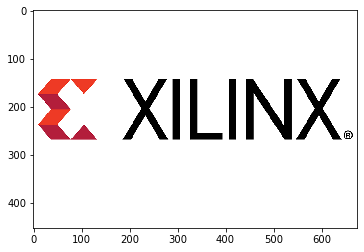

In [8]:
def dma_transfer():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
def my_callback(rgb_imgs):
    img_locations = []
    for (img_path, img) in rgb_imgs:
        print("Loading image", img_path, "into buffer for DMA transfer")
        in_buffer[:] = img    
        dma_transfer()
        print("\tDMA transfer complete")
        
        # Sho wimage
        pyplot.imshow(out_buffer)
        
        # Appending fake image location, since this example doesn't actually perform object detection 
        img_locations.append([50,358,75,263])
        
    return img_locations
        
team.run(my_callback, debug=False)

### 4. Recording results, cleanup

It is your responsibility to record your results.  You should call `team.save_results_xml(result_list, total_runtime, total_energy)` to save your results.
  * `results_list`: Each element in this list is a 4-integer list [xmin, xmax, ymin, ymax] indicating the bounding box location deterined by your object detection.  This list should have the same number of elements as there are images.  The first element in the list will correspond to image 0.jpg, etc.
  * `total_runtime`: The total runtime of your processing of all images, as described above.
  * `total_energy`: The total energy of your processing of all images, as described above.
  
The box below shows an example:


In [9]:
# These are fake object locations since the example design doesn't actually perform object detection
result_rectangle =  [[0,358,0,263],[0,1350,0,707]]

# team.save_results_xml(result_rectangle, total_time, total_energy)
# print("XML results written successfully.")

# Remember to free the contiguous memory after usage.
del in_buffer
del out_buffer

### What to submit

Submit your:
  * Notebook
  * .bit and .hwh files
  * The tcl file that can be used to create your Vivado project in 2019.1
  * Any supporting hardware files that Vivado needs (eg. IP)
  * Any other files your notebook needs to run (eg. weights file)
 